In [1]:
import tensorflow as tf
from models import decoder, encoder, vae, classifier
import pandas as pd
import pathlib
from constants import *
from hyperparameters import *
from utils import data_loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [3]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

y_train, y_validation, y_test, feature_value_names = data_loading.get_feature_dataset_y(apes_info, FEATURE_NAMES)

Found 10000 files belonging to 10000 classes.


In [4]:
x_train = data_loading.load_specific_dataset(dataset, train_ids, None)
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(BATCH_SIZE)

x_validation = data_loading.load_specific_dataset(dataset, validation_ids, None)
validation_dataset = tf.data.Dataset.zip((x_validation, y_validation)).batch(BATCH_SIZE)

x_test = data_loading.load_specific_dataset(dataset, test_ids, None)
test_dataset = tf.data.Dataset.zip((x_test, y_test)).batch(BATCH_SIZE)

In [24]:
from models import blocks


def build_multilabel_classifier2(
    encoder_model2: tf.keras.Model,
    dense_block_units: list[int],
    dense_block_dropout_rates: list[float],
    n_unique_features: list[int],
    feature_names: list[str],
) -> tf.keras.Model:
    for i1 in range(len(encoder_model2.layers)):
        encoder_model2.layers[i1].trainable = False

    inp = tf.keras.layers.Input((256, 256, 3))

    mod = tf.keras.Sequential(encoder_model.layers[:-4])
    x = mod(inp)
    x = blocks.ConvBlock(32, 3, 1, 0.2)(x)
    x = tf.keras.layers.Flatten()(x)

    for dense_block_units, dense_block_dropout_rate in zip(dense_block_units, dense_block_dropout_rates):
        x = blocks.DenseBlock(units=dense_block_units, dropout_rate=dense_block_dropout_rate)(x)

    outputs = []
    for n, feature_name1 in zip(n_unique_features, feature_names):
        outputs.append(tf.keras.layers.Dense(n, activation="sigmoid", name=feature_name1)(x))

    return tf.keras.Model(inp, outputs, name="classifier")

In [25]:
encoder_model = encoder.build_encoder(**ENCODER_MODEL_HYPERPARAMETERS)
decoder_model = decoder.build_decoder(**DECODER_MODEL_HYPERPARAMETERS)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.load_weights(MODEL_VAE_FILEPATH)

MULTI_LABEL_CLASSIFICATION_MODEL_HYPERPARAMETERS = {
    "dense_block_units": [512, 512, 512],
    "dense_block_dropout_rates": [0.10, 0.10, 0.10],
}


classifier_model = build_multilabel_classifier2(
    encoder_model, [512, 512, 512], [0.2, 0.2, 0.2], N_UNIQUE_FEATURES, FEATURE_NAMES
)

# classifier_model = classifier.build_multilabel_classifier(
#     encoder_model=encoder_model,
#     **MULTI_LABEL_CLASSIFICATION_MODEL_HYPERPARAMETERS,
#     n_unique_features=N_UNIQUE_FEATURES,
#     feature_names=FEATURE_NAMES,
# )

classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)] * len(FEATURE_NAMES),
    metrics=["accuracy"],
)

In [26]:
csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_MULTIPLE_LABEL_CLASSIFIER_FILEPATH, append=False)

classifier_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * 50),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=50,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[csv_logger],
)

classifier_model.save_weights(MODEL_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)

Epoch 1/50


2023-06-03 11:53:03.040511: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype bool and shape [7000,44]
	 [[{{node Placeholder/_20}}]]
2023-06-03 11:53:03.040784: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype bool and shape [7000,44]
	 [[{{node Placeholder/_20}}]]


54/54 [==============================] - 47s 855ms/step - loss: 1.7151 - Mouth_loss: 0.2148 - Background_loss: 0.2271 - Hat_loss: 0.1910 - Eyes_loss: 0.2615 - Clothes_loss: 0.1969 - Fur_loss: 0.2773 - Earring_loss: 0.3464 - Mouth_accuracy: 0.1370 - Background_accuracy: 0.6677 - Hat_accuracy: 0.1535 - Eyes_accuracy: 0.1023 - Clothes_accuracy: 0.1069 - Fur_accuracy: 0.1170 - Earring_accuracy: 0.6340 - val_loss: 1.7140 - val_Mouth_loss: 0.2193 - val_Background_loss: 0.1803 - val_Hat_loss: 0.2103 - val_Eyes_loss: 0.2762 - val_Clothes_loss: 0.2030 - val_Fur_loss: 0.2916 - val_Earring_loss: 0.3334 - val_Mouth_accuracy: 0.2360 - val_Background_accuracy: 0.8533 - val_Hat_accuracy: 0.2227 - val_Eyes_accuracy: 0.1707 - val_Clothes_accuracy: 0.1867 - val_Fur_accuracy: 0.1940 - val_Earring_accuracy: 0.7147
Epoch 2/50
54/54 [==============================] - 41s 764ms/step - loss: 0.9887 - Mouth_loss: 0.1165 - Background_loss: 0.0458 - Hat_loss: 0.1129 - Eyes_loss: 0.1718 - Clothes_loss: 0.1020 - F

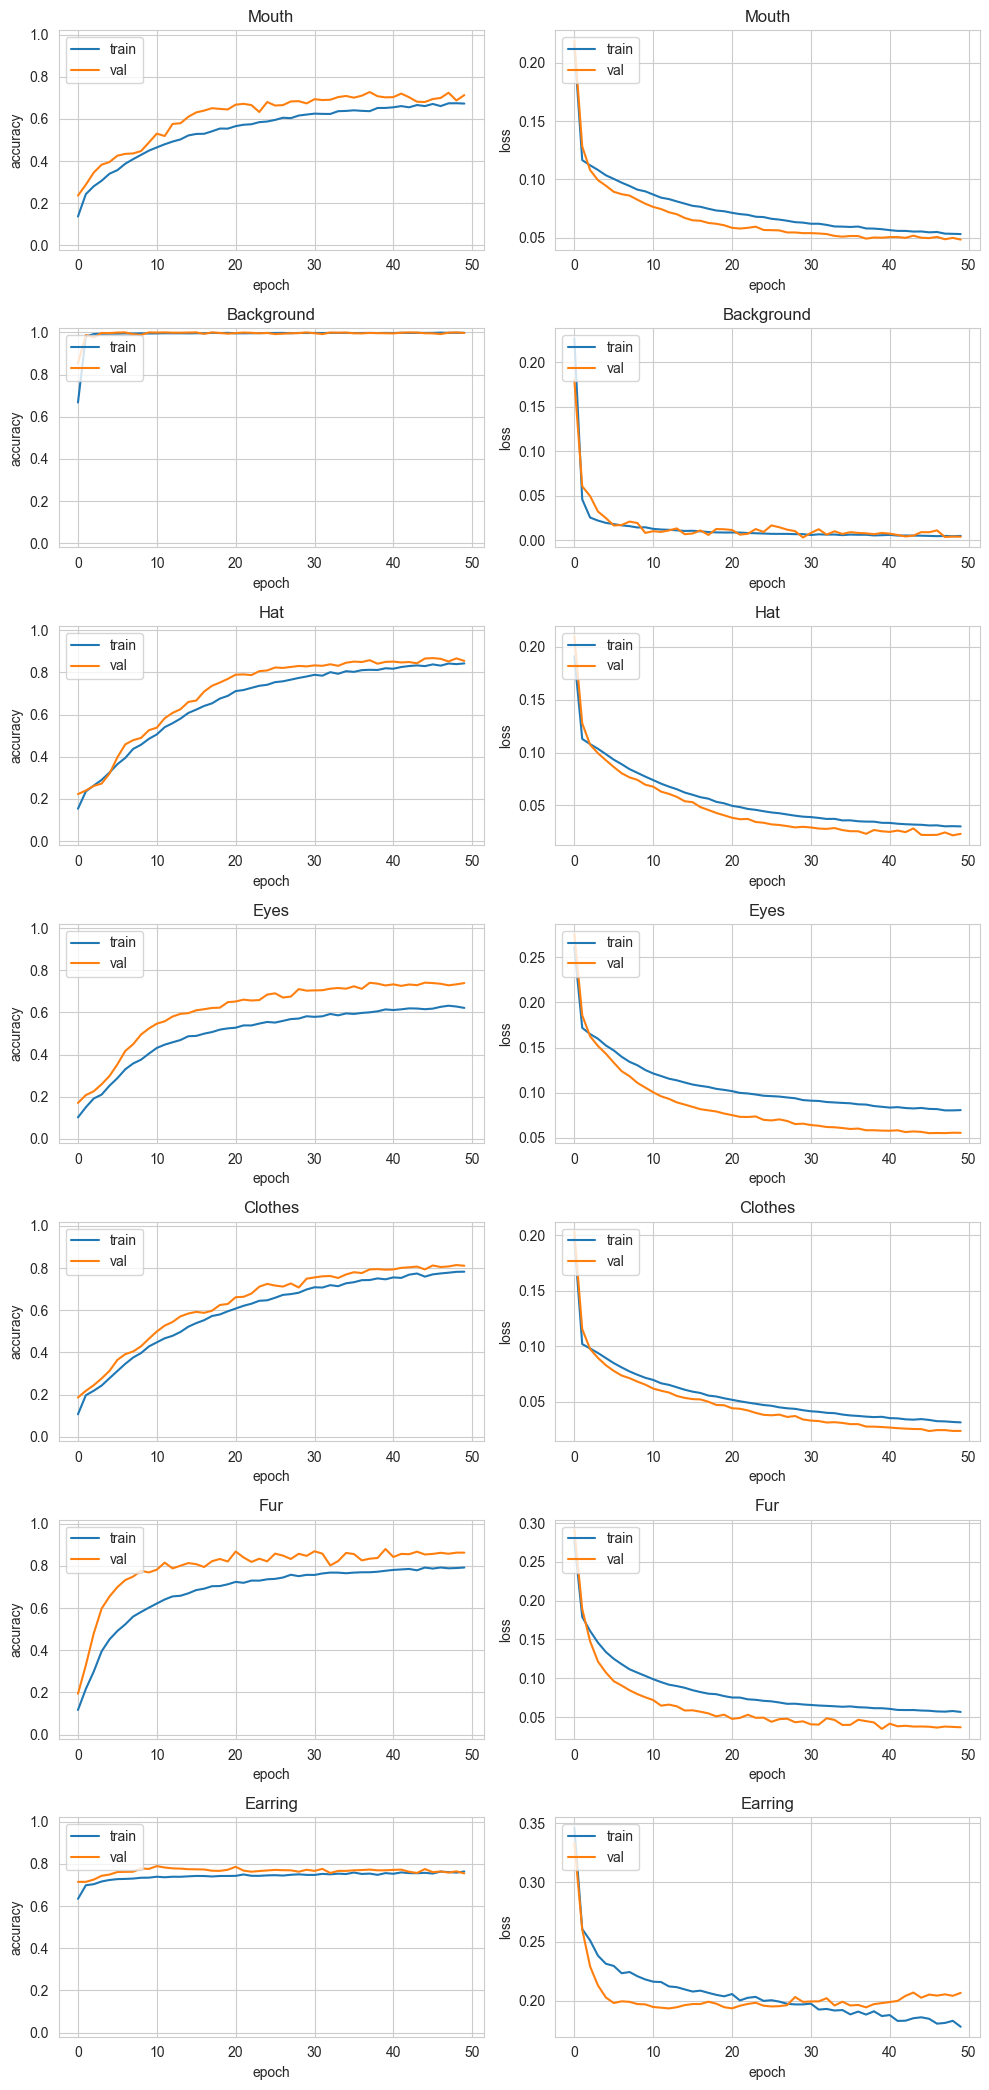

In [27]:
history_classifier_training = pd.read_csv(HISTORY_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)

plt.figure(figsize=(10, len(FEATURE_NAMES) * 3))

for i, feature_name in enumerate(FEATURE_NAMES):
    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 1)
    plt.plot(history_classifier_training[f"{feature_name}_accuracy"])
    plt.plot(history_classifier_training[f"val_{feature_name}_accuracy"])
    plt.title(feature_name)
    plt.ylim([-0.02, 1.02])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 2)
    plt.plot(history_classifier_training[f"{feature_name}_loss"])
    plt.plot(history_classifier_training[f"val_{feature_name}_loss"])
    plt.title(feature_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()

In [28]:
classifier_model.load_weights(MODEL_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)
y_test_predictions = classifier_model.predict(test_dataset)
y_test_true = list(y_test)

2023-06-03 12:27:27.182954: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype bool and shape [1500,7]
	 [[{{node Placeholder/_24}}]]
2023-06-03 12:27:27.183131: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 15s 1s/step


2023-06-03 12:27:42.365024: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [1500,7]
	 [[{{node Placeholder/_12}}]]


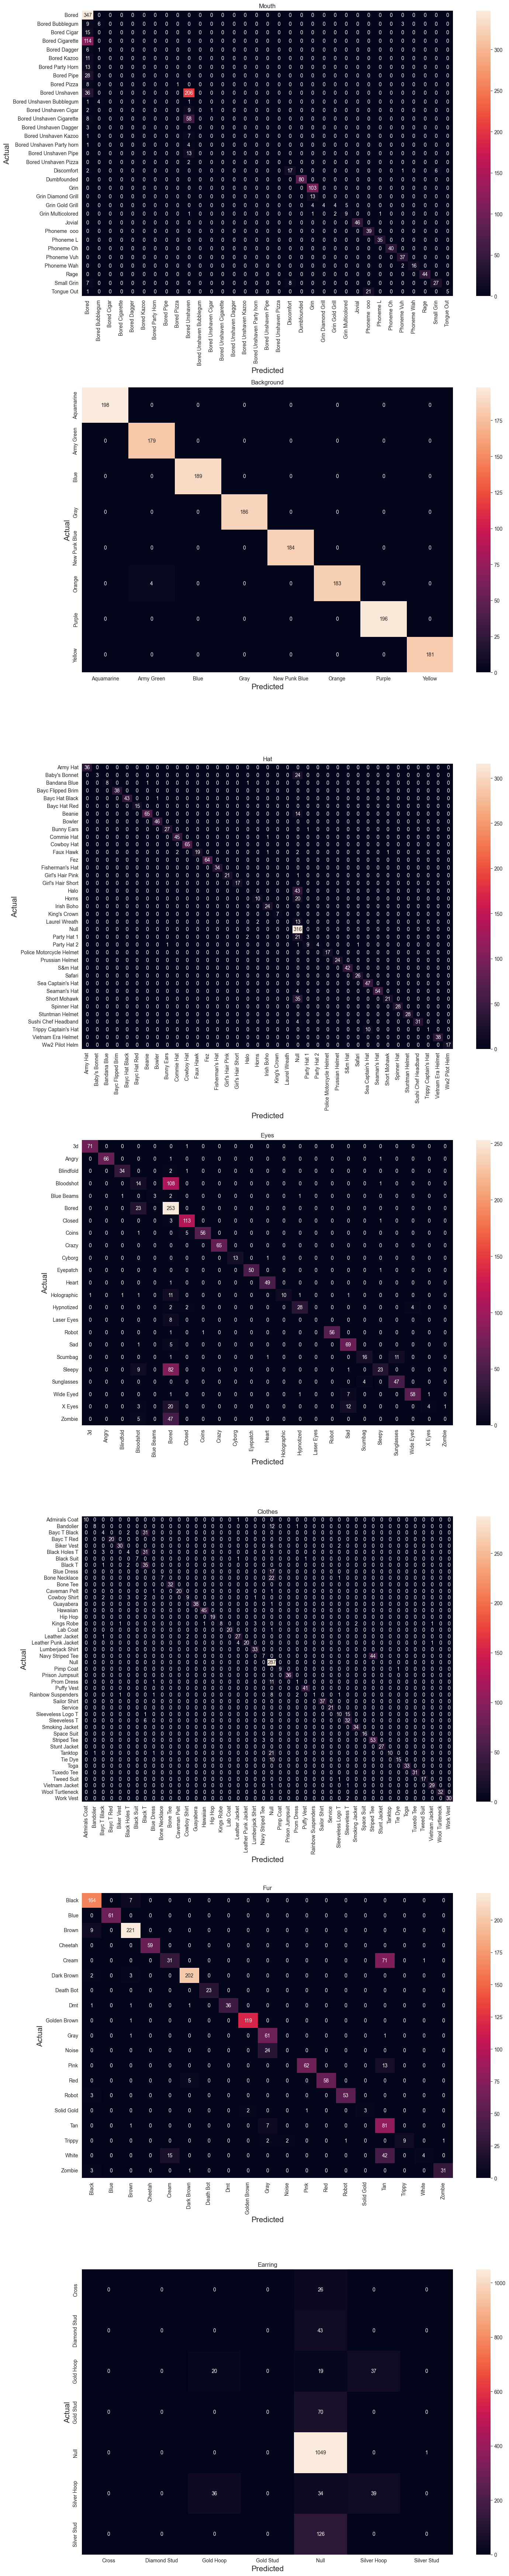

In [29]:
plt.figure(figsize=(15, len(FEATURE_NAMES) * 10))

for i, feature_name in enumerate(FEATURE_NAMES):
    cfm = confusion_matrix(np.argmax([x[i] for x in y_test_true], axis=1), np.argmax(y_test_predictions[i], axis=1))
    df_cfm = pd.DataFrame(cfm, index=feature_value_names[feature_name], columns=feature_value_names[feature_name])

    plt.subplot(len(FEATURE_NAMES), 1, i + 1)
    sns.heatmap(df_cfm, annot=True, fmt=".0f")
    plt.title(feature_name)
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()